In [1]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import pandas as pd
import os
import re

from datetime import datetime
import json

from io import BytesIO
from PIL import Image
import base64

from bokeh.plotting import figure, save, output_file
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.palettes import Category10
from bokeh.io import output_file

###!!!!!
# 1. select extracted features
# 2. set UMAP parameters
# 3. adjust run name
###!!!!!

2025-05-20 08:51:04.924171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 08:51:04.924218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 08:51:04.925574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 08:51:04.932101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-20 08:51:05.696932: W tensorflow/compiler/tf2

In [2]:
## import features and charter list

feature_path = r"/home/tschernn/becore-clustering/pickles/features_hog.pkl"
with open(feature_path, 'rb') as file:
    features = pickle.load(file)

charter_list = r"/home/tschernn/becore-clustering/pickles/charter_list.pkl"
with open(charter_list, 'rb') as file:
    charters = pickle.load(file)

features.shape

(312, 142884)

In [3]:
## option 2: reduce dimensions for visualizations (2) and save plot

# set UMAP and plot settings
vis_settings = {
    "n_components": 2, # 2 dimensions for visualization
    "n_neighbors": 5, # smaller = focus on local structure, larger = more global
    "min_dist": 0.0, # controls how tightly UMAP packs the points
    "metric": "cosine",
    "spread": 3.0,
    "random_state": 42,
    "feature_extractor": "HOG",
    "preprocessing": "Binarization",
    "charter_selection": "French & Austrian (Papal, Notary, Other)",
    "special_highlighting": "no highlighted charters",
    "notes": "baseline HOG comparison with binarization"
}

# set up output directory with timestamp
run_name = "baseline_binary_hog_umap"
timestamp = datetime.now().strftime("%Y-%m-%d_%H%M")
output_dir = f"visualizations/{timestamp}_{run_name}"

os.makedirs(output_dir, exist_ok=True)

# save experiment dir with plot and settings
with open(os.path.join(output_dir, "settings.json"), "w") as f:
    json.dump(vis_settings, f, indent=4)
output_file(os.path.join(output_dir, "plot.html"))

######

umap_model = umap.UMAP(
    n_neighbors = vis_settings['n_neighbors'],
    min_dist = vis_settings['min_dist'],
    spread = vis_settings['spread'],
    metric = vis_settings['metric'],
    n_components = vis_settings['n_components'], 
    random_state = vis_settings['random_state'])
embedding = umap_model.fit_transform(features)

# convert to a DataFrame for bokeh
df = pd.DataFrame(embedding, columns=('x', 'y'))
df['label'] = [path.split('/')[-2] for path in charters]  # categorical labels for coloring

# === Define same-scribe prefixes ===
same_scribe_prefixes = ['0c0fb', 'e37dc', '08312', 'b1a27', '60234', '0c20d']

# other_scribe_prefixes = ['7e387', 'fa17d', '2a924', '155ec']

# === Create a flag for same-scribe samples ===
same_scribe_flag = [
    any(fname.split('/')[-1].startswith(prefix) for prefix in same_scribe_prefixes) 
    for fname in charters
]

# convert images to base64 for thumbnail display
def encode_image_to_base64(image_path):
    with Image.open(image_path) as img:
        img.thumbnail((100, 100))
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode()

# Extract parent directories and simplify names after "writable_area_"
directories = [os.path.basename(os.path.dirname(path)).lower() for path in charters]
simplified_dirs = [re.sub(r'^.*writable_area_', '', d) for d in directories]

# Create unique color mapping for simplified directories
unique_dirs = list(set(simplified_dirs))
palette = Category10[10] if len(unique_dirs) <= 10 else Category10[10] * (len(unique_dirs) // 10 + 1)
color_mapper = CategoricalColorMapper(factors=unique_dirs, palette=palette[:len(unique_dirs)])

# Assign a color to each point based on its directory
data_colors = [color_mapper.palette[color_mapper.factors.index(d)] for d in simplified_dirs]

# Extract filenames and encode images
filenames = [os.path.basename(path) for path in charters]
encoded_images = [f"data:image/png;base64,{encode_image_to_base64(path)}" for path in charters]
        
# create main data dict
data = dict(
    x = embedding[:, 0],
    y = embedding[:, 1],
    directory = simplified_dirs,
    filename = filenames,
    image = encoded_images,
    same_scribe = same_scribe_flag,
    color = data_colors
)

# split data into two ColumnDataSources
same_scribe_indices = [i for i, flag in enumerate(data['same_scribe']) if flag]
other_indices = [i for i, flag in enumerate(data['same_scribe']) if not flag]

same_scribe_source = ColumnDataSource({key: [data[key][i] for i in same_scribe_indices] for key in data})
other_source = ColumnDataSource({key: [data[key][i] for i in other_indices] for key in data})

# Create figure
p = figure(title=f'{vis_settings["charter_selection"]} - {vis_settings["preprocessing"]} - {vis_settings["feature_extractor"]} - UMAP - {vis_settings["special_highlighting"]}',
           tools='pan,wheel_zoom,reset,hover,save',
           width=800, height=600)

# Plot "Other" points (colored by directory)
p.scatter(
    'x', 'y',
    source=other_source,
    legend_field='directory',
    color={'field': 'directory', 'transform': color_mapper},
    alpha=0.7, size=8
)

# Plot same-scribe charters (diamonds, red outline, same color inside)
p.scatter(
    'x', 'y',
    marker='diamond',
    source=same_scribe_source,
    size=12,
    line_color='red',
    fill_color='color',
    line_width=2,
    alpha=0.9,
    legend_label="Same Scribe Charters"
)

# Add hover tool with embedded images
hover = HoverTool(tooltips="""
    <div>
        <div><strong>Filename:</strong> @filename</div>
        <div><img src="@image" alt="Image" style="width:100px;height:100px;"/></div>
    </div>
""")
p.add_tools(hover)

# Style the legend
p.legend.title = 'Image Directories'
#p.legend.location = "best"
p.legend.click_policy = "hide"  # Allows toggling visibility of groups

save(p)

/home/tschernn/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


'/home/tschernn/becore-clustering/visualizations/2025-05-20_0851_baseline_binary_hog_umap/plot.html'

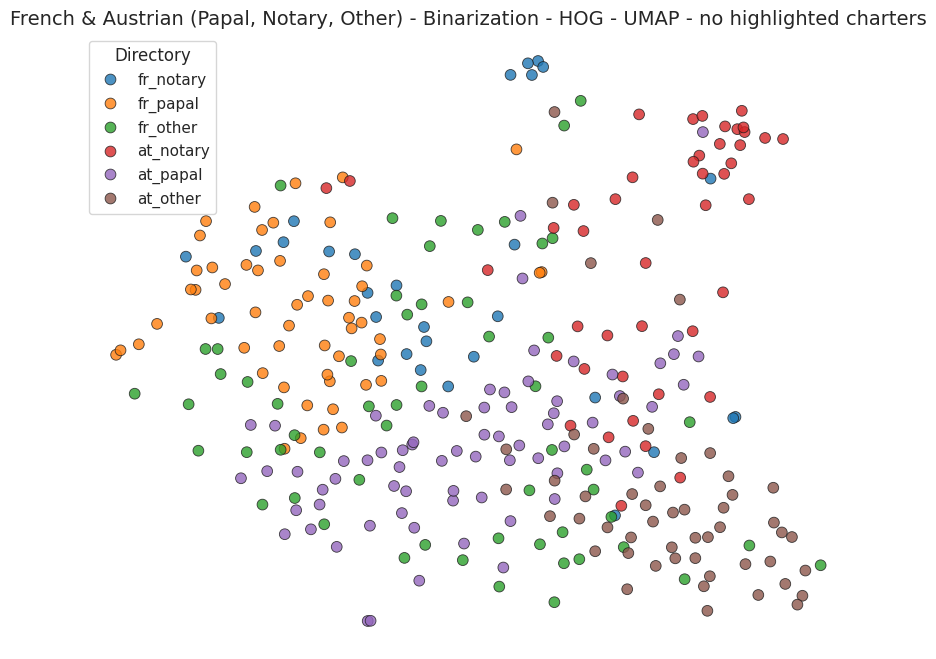

In [4]:
### create high-res static plot

# Set style
sns.set(style='white', rc={'figure.figsize':(10,8)})

# Make a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=simplified_dirs,      # or clusters, etc.
    palette='tab10',
    s=60,
    alpha=0.8,
    edgecolor='k'
)

plt.title(f'{vis_settings["charter_selection"]} - {vis_settings["preprocessing"]} - {vis_settings["feature_extractor"]} - UMAP - {vis_settings["special_highlighting"]}', fontsize=14)
plt.legend(loc='best', title='Directory')
plt.axis('off')

# Save as high-res PNG
plt.savefig(os.path.join(output_dir, "plot_highres.png"), dpi=300, bbox_inches='tight')